In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import rasterio
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.4.2)
  from scipy.sparse import csr_matrix, issparse


In [2]:
image_dir = "Data\data-20260214T164319Z-1-001\data\images"
label_dir = "Data\data-20260214T164319Z-1-001\data\labels"

image_files = sorted(os.listdir(image_dir))
label_files = sorted(os.listdir(label_dir))

print("Number of images:", len(image_files))
print("Number of labels:", len(label_files))

Number of images: 306
Number of labels: 456


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\saifk\AppData\Local\Temp\ipykernel_17024\2792036964.py:1: SyntaxWarning: invalid escape sequence '\d'
  image_dir = "Data\data-20260214T164319Z-1-001\data\images"
C:\Users\saifk\AppData\Local\Temp\ipykernel_17024\2792036964.py:2: SyntaxWarning: invalid escape sequence '\d'
  label_dir = "Data\data-20260214T164319Z-1-001\data\labels"


In [3]:
with rasterio.open(os.path.join(image_dir, image_files[0])) as src:
    sample_image = src.read()  

sample_image = np.transpose(sample_image, (1, 2, 0))  # convert to (H, W, C)

sample_mask = cv2.imread(os.path.join(label_dir, label_files[0]), 0)

print("Image shape:", sample_image.shape)
print("Mask shape:", sample_mask.shape)

sample_image = sample_image.astype(np.float32)

for c in range(sample_image.shape[-1]):
    band = sample_image[:, :, c]
    min_val = band.min()
    max_val = band.max()
    if max_val > min_val:
        sample_image[:, :, c] = (band - min_val) / (max_val - min_val)


Image shape: (128, 128, 12)
Mask shape: (128, 128)


c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


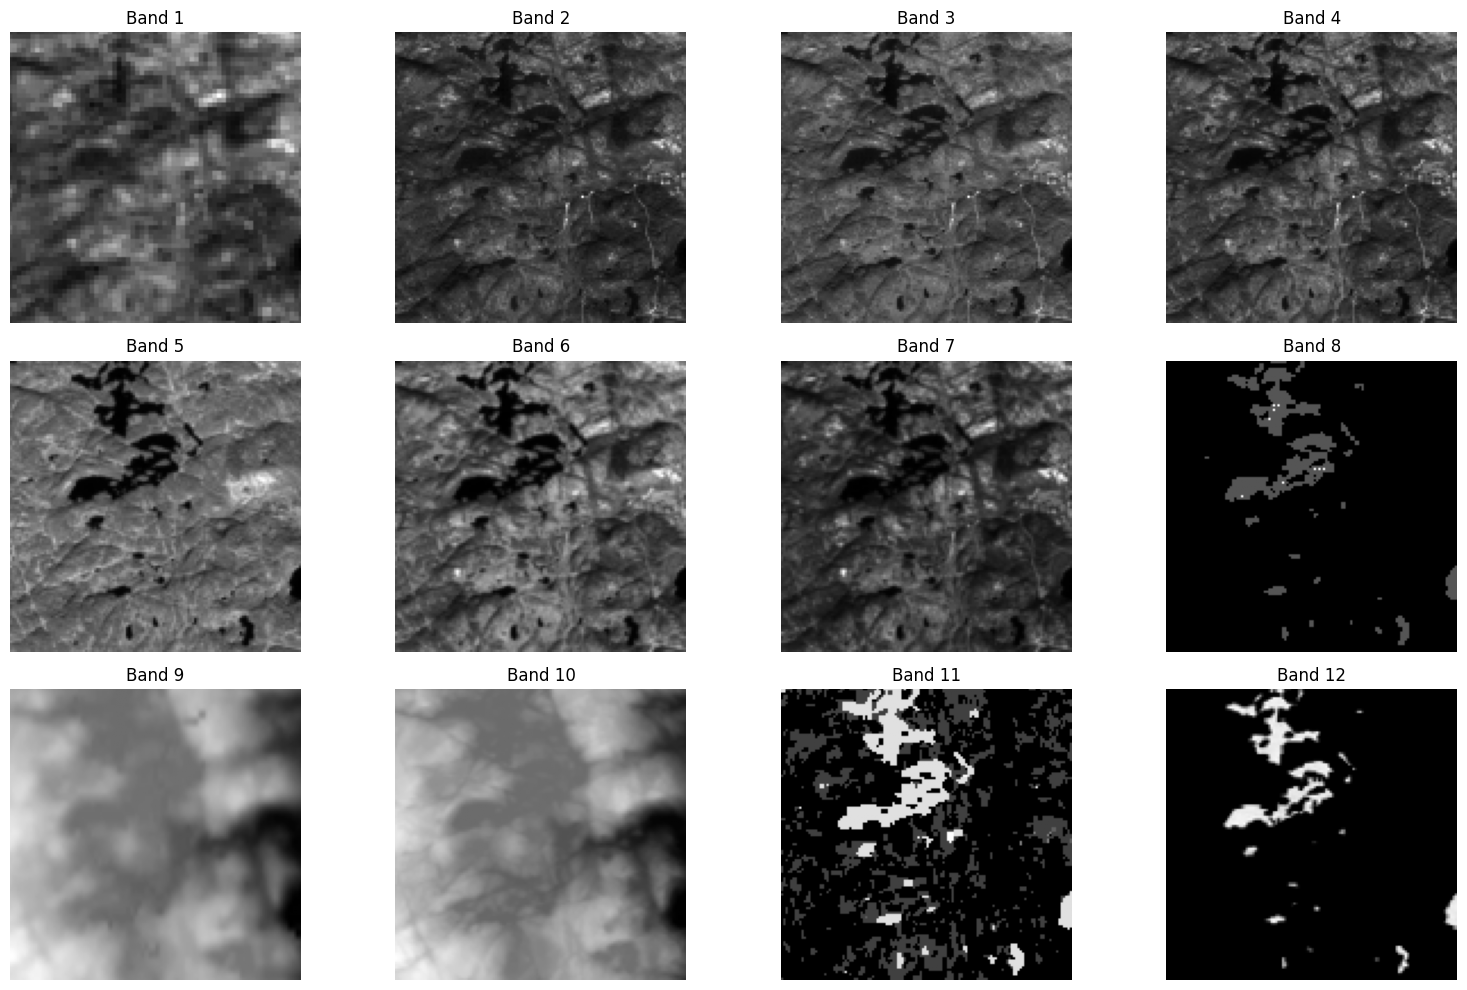

In [4]:
plt.figure(figsize=(16,10))

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(sample_image[:,:,i], cmap='gray')
    plt.title(f'Band {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


### Model Arch

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super().__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bridge = DoubleConv(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))

        bridge = self.bridge(self.pool3(d3))

        u3 = self.up3(bridge)
        u3 = self.conv3(torch.cat([u3, d3], dim=1))

        u2 = self.up2(u3)
        u2 = self.conv2(torch.cat([u2, d2], dim=1))

        u1 = self.up1(u2)
        u1 = self.conv1(torch.cat([u1, d1], dim=1))

        return self.final(u1)


In [6]:
model = UNet(12, 1)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total parameters:", total_params)
print("Trainable parameters:", trainable_params)


Total parameters: 7708161
Trainable parameters: 7708161


### Testing Diffrent Channels 

In [7]:
bands_A = list(range(12))
bands_B = [0, 1, 4, 5, 6, 11]
bands_C = [3, 2, 1]  # R,G,B
bands_D = [4, 5, 6]
bands_E = [0, 1, 4, 5, 6, 11]  # + NDWI computed later
bands_F = [2 , 3 , 4 , 5 , 7 , 10 , 11]


In [8]:
class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir, selected_bands, add_ndwi=False):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))
        self.selected_bands = selected_bands
        self.add_ndwi = add_ndwi

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)

        with rasterio.open(img_path) as src:
            image = src.read()

        image = np.transpose(image, (1,2,0)).astype(np.float32)

        image = image[:, :, self.selected_bands]

        if self.add_ndwi:
            green = image[:, :, 2] if 2 in self.selected_bands else image[:, :, 1]
            nir = image[:, :, 4] if 4 in self.selected_bands else image[:, :, -1]

            ndwi = (green - nir) / (green + nir + 1e-8)
            ndwi = np.expand_dims(ndwi, axis=-1)

            image = np.concatenate([image, ndwi], axis=-1)

        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        image = torch.tensor(image).permute(2,0,1)
        mask = torch.tensor(mask).unsqueeze(0)

        return image, mask


In [9]:
def calculate_metrics(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = (preds * masks).sum()
    FP = (preds * (1 - masks)).sum()
    FN = ((1 - preds) * masks).sum()

    iou = TP / (TP + FP + FN + 1e-8)

    return iou.item()

In [10]:
def train_model(selected_bands, add_ndwi=False, epochs=20):

    dataset = WaterDataset(image_dir, label_dir, selected_bands, add_ndwi)

    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    in_channels = len(selected_bands) + (1 if add_ndwi else 0)
    model = UNet(in_channels=in_channels, out_channels=1).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    train_losses, val_losses = [], []
    train_ious, val_ious = [], []

    for epoch in range(epochs):

        # ---------------- TRAIN ----------------
        model.train()
        train_loss = 0
        train_iou = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

        for images, masks in train_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            iou = calculate_metrics(preds, masks)
            train_iou += iou

            train_bar.set_postfix(loss=loss.item())

        train_loss /= len(train_loader)
        train_iou /= len(train_loader)

        train_losses.append(train_loss)
        train_ious.append(train_iou)


        # ---------------- VALIDATION ----------------
        model.eval()
        val_loss = 0
        val_iou = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

            for images, masks in val_bar:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()

                preds = torch.sigmoid(outputs)
                preds = (preds > 0.5).float()

                iou  = calculate_metrics(preds, masks)
                val_iou += iou

                val_bar.set_postfix(val_loss=loss.item())

        val_loss /= len(val_loader)
        val_iou /= len(val_loader)

        val_losses.append(val_loss)
        val_ious.append(val_iou)

        print(f"\nEpoch {epoch+1}")
        print(f"Train -> Loss:{train_loss:.4f} | IoU:{train_iou:.4f}")
        print(f"Val   -> Loss:{val_loss:.4f} | IoU:{val_iou:.4f}")

    return {
        "model": model,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_ious": train_ious,
        "val_ious": val_ious,
    }


In [11]:
results = {}

print("\n" + "="*60)
print("Training Model: All 12 Bands")
print("="*60)
results["All 12"] = train_model(bands_A)

print("\n" + "="*60)
print("Training Model: 6 Water Bands")
print("="*60)
results["6 Water Bands"] = train_model(bands_B)

print("\n" + "="*60)
print("Training Model: RGB")
print("="*60)
results["RGB"] = train_model(bands_C)

print("\n" + "="*60)
print("Training Model: NIR + SWIR")
print("="*60)
results["NIR+SWIR"] = train_model(bands_D)

print("\n" + "="*60)
print("Training Model: 6 Bands + NDWI")
print("="*60)
results["6 Bands + NDWI"] = train_model(bands_B, add_ndwi=True)

print("\n" + "="*60)
print("Training Model: 7 Bands")
print("="*60)
results["7 Bands"] = train_model(bands_F)



Training Model: All 12 Bands


Epoch 1/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)
Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s, val_loss=0.665]



Epoch 1
Train -> Loss:0.5970 | IoU:0.3547
Val   -> Loss:0.6639 | IoU:0.0000


Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.73it/s, val_loss=0.619]



Epoch 2
Train -> Loss:0.4713 | IoU:0.5118
Val   -> Loss:0.6171 | IoU:0.0000


Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s, val_loss=0.614]



Epoch 3
Train -> Loss:0.4269 | IoU:0.5317
Val   -> Loss:0.6112 | IoU:0.0000


Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.47it/s, val_loss=0.604]



Epoch 4
Train -> Loss:0.3839 | IoU:0.5609
Val   -> Loss:0.5985 | IoU:0.0000


Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.19it/s, val_loss=0.609]



Epoch 5
Train -> Loss:0.3726 | IoU:0.5706
Val   -> Loss:0.6036 | IoU:0.0000


Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.20it/s, val_loss=0.65] 



Epoch 6
Train -> Loss:0.3973 | IoU:0.5272
Val   -> Loss:0.6458 | IoU:0.0000


Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.45it/s, val_loss=0.623]



Epoch 7
Train -> Loss:0.3406 | IoU:0.6233
Val   -> Loss:0.6187 | IoU:0.0000


Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.31it/s, val_loss=0.611]



Epoch 8
Train -> Loss:0.3435 | IoU:0.5967
Val   -> Loss:0.6064 | IoU:0.0000


Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.23it/s, val_loss=0.647]



Epoch 9
Train -> Loss:0.3303 | IoU:0.5974
Val   -> Loss:0.6420 | IoU:0.0000


Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.37it/s, val_loss=0.667]



Epoch 10
Train -> Loss:0.3363 | IoU:0.5893
Val   -> Loss:0.6639 | IoU:0.0005


Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.34it/s, val_loss=0.75] 



Epoch 11
Train -> Loss:0.3328 | IoU:0.5989
Val   -> Loss:0.7386 | IoU:0.2875


Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.24it/s, val_loss=0.671]



Epoch 12
Train -> Loss:0.3250 | IoU:0.6130
Val   -> Loss:0.6624 | IoU:0.0000


Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.30it/s, val_loss=0.704]



Epoch 13
Train -> Loss:0.3195 | IoU:0.5976
Val   -> Loss:0.6906 | IoU:0.2853


Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.98it/s, val_loss=0.662]



Epoch 14
Train -> Loss:0.3136 | IoU:0.6044
Val   -> Loss:0.6504 | IoU:0.0000


Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.32it/s, val_loss=0.589]



Epoch 15
Train -> Loss:0.3417 | IoU:0.5563
Val   -> Loss:0.5817 | IoU:0.0000


Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.93it/s, val_loss=0.622]



Epoch 16
Train -> Loss:0.3182 | IoU:0.5865
Val   -> Loss:0.6114 | IoU:0.0000


Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s, val_loss=0.591]



Epoch 17
Train -> Loss:0.3062 | IoU:0.6127
Val   -> Loss:0.5812 | IoU:0.0000


Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.09it/s, val_loss=0.637]



Epoch 18
Train -> Loss:0.2856 | IoU:0.6432
Val   -> Loss:0.6287 | IoU:0.0000


Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s, val_loss=0.675]



Epoch 19
Train -> Loss:0.2959 | IoU:0.6212
Val   -> Loss:0.6698 | IoU:0.2942


Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.19it/s, val_loss=0.689]



Epoch 20
Train -> Loss:0.2970 | IoU:0.6142
Val   -> Loss:0.6836 | IoU:0.2935

Training Model: 6 Water Bands


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  5.77it/s, val_loss=0.625]



Epoch 1
Train -> Loss:0.5280 | IoU:0.4692
Val   -> Loss:0.6284 | IoU:0.2184


Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.51it/s, val_loss=0.492]



Epoch 2
Train -> Loss:0.4007 | IoU:0.6149
Val   -> Loss:0.4821 | IoU:0.4504


Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.47it/s, val_loss=0.383]



Epoch 3
Train -> Loss:0.3710 | IoU:0.6151
Val   -> Loss:0.3830 | IoU:0.6143


Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.45it/s, val_loss=0.477]



Epoch 4
Train -> Loss:0.3370 | IoU:0.6594
Val   -> Loss:0.4242 | IoU:0.5585


Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.28it/s, val_loss=0.262]



Epoch 5
Train -> Loss:0.3488 | IoU:0.6244
Val   -> Loss:0.2812 | IoU:0.6557


Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.45it/s, val_loss=0.436]



Epoch 6
Train -> Loss:0.3189 | IoU:0.6689
Val   -> Loss:0.3945 | IoU:0.5959


Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.45it/s, val_loss=0.279]



Epoch 7
Train -> Loss:0.3301 | IoU:0.6344
Val   -> Loss:0.3004 | IoU:0.6661


Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.38it/s, val_loss=0.25] 



Epoch 8
Train -> Loss:0.3063 | IoU:0.6740
Val   -> Loss:0.2710 | IoU:0.6826


Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.38it/s, val_loss=0.276]



Epoch 9
Train -> Loss:0.3049 | IoU:0.6868
Val   -> Loss:0.2804 | IoU:0.6953


Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.29it/s, val_loss=0.288]



Epoch 10
Train -> Loss:0.3060 | IoU:0.6711
Val   -> Loss:0.3134 | IoU:0.6391


Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.30it/s, val_loss=0.256]



Epoch 11
Train -> Loss:0.2941 | IoU:0.6817
Val   -> Loss:0.2700 | IoU:0.6874


Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.42it/s, val_loss=0.231]



Epoch 12
Train -> Loss:0.2847 | IoU:0.7041
Val   -> Loss:0.2500 | IoU:0.6886


Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.86it/s, val_loss=0.223]



Epoch 13
Train -> Loss:0.2716 | IoU:0.7177
Val   -> Loss:0.2461 | IoU:0.6998


Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.37it/s, val_loss=0.214]



Epoch 14
Train -> Loss:0.2738 | IoU:0.7137
Val   -> Loss:0.2594 | IoU:0.6874


Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.33it/s, val_loss=0.223]



Epoch 15
Train -> Loss:0.2786 | IoU:0.6911
Val   -> Loss:0.2470 | IoU:0.7131


Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.20it/s, val_loss=0.22] 



Epoch 16
Train -> Loss:0.2566 | IoU:0.7397
Val   -> Loss:0.2439 | IoU:0.7161


Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.38it/s, val_loss=0.198]



Epoch 17
Train -> Loss:0.2493 | IoU:0.7329
Val   -> Loss:0.2345 | IoU:0.7025


Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.18it/s, val_loss=0.272]



Epoch 18
Train -> Loss:0.2596 | IoU:0.7079
Val   -> Loss:0.2600 | IoU:0.6940


Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.09it/s, val_loss=0.214]



Epoch 19
Train -> Loss:0.2392 | IoU:0.7543
Val   -> Loss:0.2321 | IoU:0.7342


Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.18it/s, val_loss=0.208]



Epoch 20
Train -> Loss:0.2500 | IoU:0.7198
Val   -> Loss:0.2322 | IoU:0.7237

Training Model: RGB


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.51it/s, val_loss=0.75] 



Epoch 1
Train -> Loss:0.6795 | IoU:0.3277
Val   -> Loss:0.7433 | IoU:0.2050


Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.22it/s, val_loss=1.94]



Epoch 2
Train -> Loss:0.6093 | IoU:0.3718
Val   -> Loss:1.9110 | IoU:0.2050


Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.41it/s, val_loss=1.37]



Epoch 3
Train -> Loss:0.5471 | IoU:0.4217
Val   -> Loss:1.4076 | IoU:0.2524


Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.32it/s, val_loss=0.629]



Epoch 4
Train -> Loss:0.5498 | IoU:0.3998
Val   -> Loss:0.6907 | IoU:0.3202


Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s, val_loss=0.445]



Epoch 5
Train -> Loss:0.5200 | IoU:0.3880
Val   -> Loss:0.4841 | IoU:0.3852


Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.49it/s, val_loss=0.418]



Epoch 6
Train -> Loss:0.4933 | IoU:0.4193
Val   -> Loss:0.4383 | IoU:0.4122


Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.33it/s, val_loss=0.427]



Epoch 7
Train -> Loss:0.4639 | IoU:0.4533
Val   -> Loss:0.4266 | IoU:0.4350


Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.25it/s, val_loss=0.422]



Epoch 8
Train -> Loss:0.4635 | IoU:0.4671
Val   -> Loss:0.4881 | IoU:0.4352


Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.37it/s, val_loss=0.435]



Epoch 9
Train -> Loss:0.4680 | IoU:0.4062
Val   -> Loss:0.4437 | IoU:0.3966


Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.60it/s, val_loss=0.381]



Epoch 10
Train -> Loss:0.4497 | IoU:0.4613
Val   -> Loss:0.3950 | IoU:0.4248


Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.56it/s, val_loss=0.39] 



Epoch 11
Train -> Loss:0.4700 | IoU:0.4356
Val   -> Loss:0.4586 | IoU:0.4257


Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.36it/s, val_loss=0.432]



Epoch 12
Train -> Loss:0.4334 | IoU:0.4640
Val   -> Loss:0.4386 | IoU:0.4592


Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.53it/s, val_loss=0.393]



Epoch 13
Train -> Loss:0.4269 | IoU:0.4691
Val   -> Loss:0.4501 | IoU:0.4063


Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.10it/s, val_loss=0.338]



Epoch 14
Train -> Loss:0.4390 | IoU:0.4554
Val   -> Loss:0.3969 | IoU:0.4199


Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.77it/s, val_loss=0.424]



Epoch 15
Train -> Loss:0.4328 | IoU:0.4677
Val   -> Loss:0.4052 | IoU:0.4506


Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.31it/s, val_loss=0.391]



Epoch 16
Train -> Loss:0.3916 | IoU:0.5253
Val   -> Loss:0.3938 | IoU:0.4486


Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.22it/s, val_loss=0.355]



Epoch 17
Train -> Loss:0.4130 | IoU:0.5128
Val   -> Loss:0.3519 | IoU:0.4151


Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.37it/s, val_loss=0.482]



Epoch 18
Train -> Loss:0.3836 | IoU:0.5328
Val   -> Loss:0.4666 | IoU:0.4270


Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.31it/s, val_loss=0.395]



Epoch 19
Train -> Loss:0.3807 | IoU:0.5478
Val   -> Loss:0.4086 | IoU:0.4528


Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.16it/s, val_loss=0.415]



Epoch 20
Train -> Loss:0.3852 | IoU:0.5333
Val   -> Loss:0.3971 | IoU:0.5036

Training Model: NIR + SWIR


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.35it/s, val_loss=0.622]



Epoch 1
Train -> Loss:0.4908 | IoU:0.4831
Val   -> Loss:0.6235 | IoU:0.0000


Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.51it/s, val_loss=0.513]



Epoch 2
Train -> Loss:0.3993 | IoU:0.5698
Val   -> Loss:0.5090 | IoU:0.2614


Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.32it/s, val_loss=0.345]



Epoch 3
Train -> Loss:0.3825 | IoU:0.5583
Val   -> Loss:0.3462 | IoU:0.6655


Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.23it/s, val_loss=0.339]



Epoch 4
Train -> Loss:0.3641 | IoU:0.5818
Val   -> Loss:0.3369 | IoU:0.6832


Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.67it/s, val_loss=0.282]



Epoch 5
Train -> Loss:0.3613 | IoU:0.5653
Val   -> Loss:0.2910 | IoU:0.7413


Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.34it/s, val_loss=0.269]



Epoch 6
Train -> Loss:0.3600 | IoU:0.5429
Val   -> Loss:0.2862 | IoU:0.7436


Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.54it/s, val_loss=0.284]



Epoch 7
Train -> Loss:0.3383 | IoU:0.5813
Val   -> Loss:0.2964 | IoU:0.7321


Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.13it/s, val_loss=0.444]



Epoch 8
Train -> Loss:0.3341 | IoU:0.5923
Val   -> Loss:0.5011 | IoU:0.5159


Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s, val_loss=0.277]



Epoch 9
Train -> Loss:0.3353 | IoU:0.5854
Val   -> Loss:0.2823 | IoU:0.7269


Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.63it/s, val_loss=0.255]



Epoch 10
Train -> Loss:0.3350 | IoU:0.5860
Val   -> Loss:0.2687 | IoU:0.7489


Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.36it/s, val_loss=0.242]



Epoch 11
Train -> Loss:0.3291 | IoU:0.5973
Val   -> Loss:0.2571 | IoU:0.7503


Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.43it/s, val_loss=0.28] 



Epoch 12
Train -> Loss:0.3122 | IoU:0.6126
Val   -> Loss:0.2987 | IoU:0.7394


Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.45it/s, val_loss=0.279]



Epoch 13
Train -> Loss:0.3027 | IoU:0.6229
Val   -> Loss:0.2681 | IoU:0.7537


Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.58it/s, val_loss=0.276]



Epoch 14
Train -> Loss:0.2931 | IoU:0.6421
Val   -> Loss:0.2816 | IoU:0.7319


Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.54it/s, val_loss=0.231]



Epoch 15
Train -> Loss:0.2838 | IoU:0.6482
Val   -> Loss:0.2620 | IoU:0.7051


Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.31it/s, val_loss=0.224]



Epoch 16
Train -> Loss:0.2906 | IoU:0.6356
Val   -> Loss:0.2441 | IoU:0.7562


Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.51it/s, val_loss=0.206]



Epoch 17
Train -> Loss:0.2751 | IoU:0.6737
Val   -> Loss:0.2294 | IoU:0.7735


Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.27it/s, val_loss=0.296]



Epoch 18
Train -> Loss:0.2701 | IoU:0.6700
Val   -> Loss:0.3049 | IoU:0.6769


Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.51it/s, val_loss=0.229]



Epoch 19
Train -> Loss:0.2626 | IoU:0.6952
Val   -> Loss:0.2381 | IoU:0.7576


Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.56it/s, val_loss=0.187]



Epoch 20
Train -> Loss:0.2682 | IoU:0.6894
Val   -> Loss:0.2181 | IoU:0.7813

Training Model: 6 Bands + NDWI


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.96it/s, val_loss=0.676]



Epoch 1
Train -> Loss:0.5801 | IoU:0.4472
Val   -> Loss:0.6744 | IoU:0.4431


Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.27it/s, val_loss=0.523]



Epoch 2
Train -> Loss:0.4247 | IoU:0.6329
Val   -> Loss:0.5140 | IoU:0.3764


Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.16it/s, val_loss=0.406]



Epoch 3
Train -> Loss:0.3888 | IoU:0.6594
Val   -> Loss:0.3876 | IoU:0.5089


Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s, val_loss=0.372]



Epoch 4
Train -> Loss:0.3794 | IoU:0.6544
Val   -> Loss:0.3656 | IoU:0.5736


Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s, val_loss=0.387]



Epoch 5
Train -> Loss:0.3597 | IoU:0.6685
Val   -> Loss:0.3637 | IoU:0.5839


Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.75it/s, val_loss=0.377]



Epoch 6
Train -> Loss:0.3602 | IoU:0.6644
Val   -> Loss:0.3512 | IoU:0.5844


Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.29it/s, val_loss=0.379]



Epoch 7
Train -> Loss:0.3472 | IoU:0.6681
Val   -> Loss:0.3681 | IoU:0.5854


Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.23it/s, val_loss=0.37]



Epoch 8
Train -> Loss:0.3227 | IoU:0.7126
Val   -> Loss:0.3537 | IoU:0.5839


Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.93it/s, val_loss=0.416]



Epoch 9
Train -> Loss:0.3431 | IoU:0.6514
Val   -> Loss:0.3988 | IoU:0.5704


Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.99it/s, val_loss=0.352]



Epoch 10
Train -> Loss:0.3353 | IoU:0.6666
Val   -> Loss:0.3398 | IoU:0.5915


Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.21it/s, val_loss=0.353]



Epoch 11
Train -> Loss:0.3133 | IoU:0.7098
Val   -> Loss:0.3368 | IoU:0.6004


Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.05it/s, val_loss=0.345]



Epoch 12
Train -> Loss:0.3030 | IoU:0.7137
Val   -> Loss:0.3180 | IoU:0.5956


Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.38it/s, val_loss=0.336]



Epoch 13
Train -> Loss:0.2993 | IoU:0.7140
Val   -> Loss:0.3008 | IoU:0.6194


Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s, val_loss=0.364]



Epoch 14
Train -> Loss:0.2932 | IoU:0.7175
Val   -> Loss:0.3564 | IoU:0.6282


Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.05it/s, val_loss=0.327]



Epoch 15
Train -> Loss:0.2999 | IoU:0.6989
Val   -> Loss:0.3100 | IoU:0.6101


Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.20it/s, val_loss=0.348]



Epoch 16
Train -> Loss:0.2917 | IoU:0.7034
Val   -> Loss:0.3073 | IoU:0.6238


Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.22it/s, val_loss=0.343]



Epoch 17
Train -> Loss:0.2799 | IoU:0.7336
Val   -> Loss:0.3004 | IoU:0.5967


Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.08it/s, val_loss=0.329]



Epoch 18
Train -> Loss:0.2835 | IoU:0.7082
Val   -> Loss:0.2955 | IoU:0.5930


Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.22it/s, val_loss=0.327]



Epoch 19
Train -> Loss:0.2640 | IoU:0.7383
Val   -> Loss:0.2838 | IoU:0.6314


Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.98it/s, val_loss=0.333]



Epoch 20
Train -> Loss:0.2551 | IoU:0.7546
Val   -> Loss:0.2939 | IoU:0.6091

Training Model: 7 Bands


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.55it/s, val_loss=0.651]



Epoch 1
Train -> Loss:0.5396 | IoU:0.3699
Val   -> Loss:0.6448 | IoU:0.0000


Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s, val_loss=0.552]



Epoch 2
Train -> Loss:0.3985 | IoU:0.6104
Val   -> Loss:0.5327 | IoU:0.2872


Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.27it/s, val_loss=0.527]



Epoch 3
Train -> Loss:0.3783 | IoU:0.5814
Val   -> Loss:0.5416 | IoU:0.4413


Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.12it/s, val_loss=0.53] 



Epoch 4
Train -> Loss:0.3533 | IoU:0.6082
Val   -> Loss:0.5060 | IoU:0.1055


Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.06it/s, val_loss=0.565]



Epoch 5
Train -> Loss:0.3405 | IoU:0.6163
Val   -> Loss:0.5609 | IoU:0.3912


Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s, val_loss=0.527]



Epoch 6
Train -> Loss:0.3271 | IoU:0.6355
Val   -> Loss:0.4941 | IoU:0.1833


Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.34it/s, val_loss=0.547]



Epoch 7
Train -> Loss:0.3224 | IoU:0.6261
Val   -> Loss:0.4959 | IoU:0.0000


Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.92it/s, val_loss=0.506]



Epoch 8
Train -> Loss:0.3191 | IoU:0.6112
Val   -> Loss:0.4615 | IoU:0.2305


Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.34it/s, val_loss=0.536]



Epoch 9
Train -> Loss:0.3115 | IoU:0.6335
Val   -> Loss:0.4898 | IoU:0.0050


Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.32it/s, val_loss=0.507]



Epoch 10
Train -> Loss:0.3221 | IoU:0.6200
Val   -> Loss:0.4656 | IoU:0.1894


Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.84it/s, val_loss=0.518]



Epoch 11
Train -> Loss:0.3053 | IoU:0.6316
Val   -> Loss:0.4878 | IoU:0.0860


Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.81it/s, val_loss=0.464]



Epoch 12
Train -> Loss:0.3080 | IoU:0.6122
Val   -> Loss:0.4372 | IoU:0.2819


Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s, val_loss=0.481]



Epoch 13
Train -> Loss:0.2924 | IoU:0.6421
Val   -> Loss:0.4586 | IoU:0.2293


Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.04it/s, val_loss=0.48] 



Epoch 14
Train -> Loss:0.2938 | IoU:0.6394
Val   -> Loss:0.4441 | IoU:0.2430


Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.90it/s, val_loss=0.495]



Epoch 15
Train -> Loss:0.2881 | IoU:0.6541
Val   -> Loss:0.4765 | IoU:0.2346


Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.69it/s, val_loss=0.499]



Epoch 16
Train -> Loss:0.2891 | IoU:0.6323
Val   -> Loss:0.4603 | IoU:0.2467


Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.24it/s, val_loss=0.499]



Epoch 17
Train -> Loss:0.2818 | IoU:0.6516
Val   -> Loss:0.4996 | IoU:0.2412


Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.00it/s, val_loss=0.531]



Epoch 18
Train -> Loss:0.2767 | IoU:0.6743
Val   -> Loss:0.4728 | IoU:0.0555


Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.01it/s, val_loss=0.665]



Epoch 19
Train -> Loss:0.2605 | IoU:0.6897
Val   -> Loss:0.6882 | IoU:0.2833


Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.04it/s, val_loss=0.661]


Epoch 20
Train -> Loss:0.2667 | IoU:0.6580
Val   -> Loss:0.6577 | IoU:0.2958


In [12]:
print("\n" + "="*60)
print("IoU Comparison")
print("="*60)

sorted_results = sorted(
    results.items(),
    key=lambda x: x[1]["val_ious"][-1],  
    reverse=True
)

for i, (name, data) in enumerate(sorted_results, 1):
    final_iou = data["val_ious"][-1]
    print(f"{i}. {name:<20} | IoU: {final_iou:.4f}")



IoU Comparison
1. NIR+SWIR             | IoU: 0.7813
2. 6 Water Bands        | IoU: 0.7237
3. 6 Bands + NDWI       | IoU: 0.6091
4. RGB                  | IoU: 0.5036
5. 7 Bands              | IoU: 0.2958
6. All 12               | IoU: 0.2935


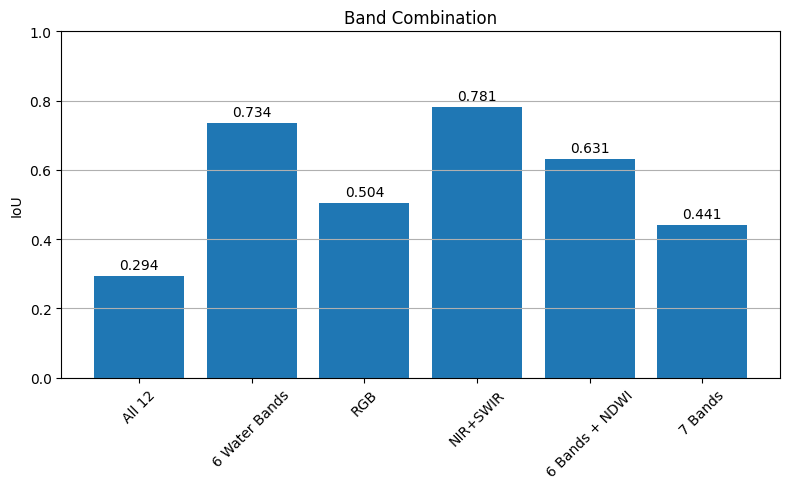

In [13]:
model_names = []
iou_scores = []

for name, data in results.items():
    best_iou = max(data["val_ious"])   # best validation IoU
    model_names.append(name)
    iou_scores.append(best_iou)

plt.figure(figsize=(8,5))
plt.bar(model_names, iou_scores)

plt.xticks(rotation=45)
plt.ylabel("IoU")
plt.title("Band Combination")
plt.ylim(0, 1)
plt.grid(axis="y")

for i, v in enumerate(iou_scores):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()

### Model A (6 Bands)

In [14]:
selected_bands = [0, 1, 4, 5, 6, 11]

class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)


        with rasterio.open(img_path) as src:
            image = src.read()  

        image = np.transpose(image, (1, 2, 0))  
        image = image[:, :, selected_bands]
        image = image.astype(np.float32)


        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:
            raise ValueError(f"Mask not found: {mask_path}")

        mask = (mask > 0).astype(np.float32)  
        image = torch.tensor(image).permute(2, 0, 1)  
        mask = torch.tensor(mask).unsqueeze(0)       

        return image, mask


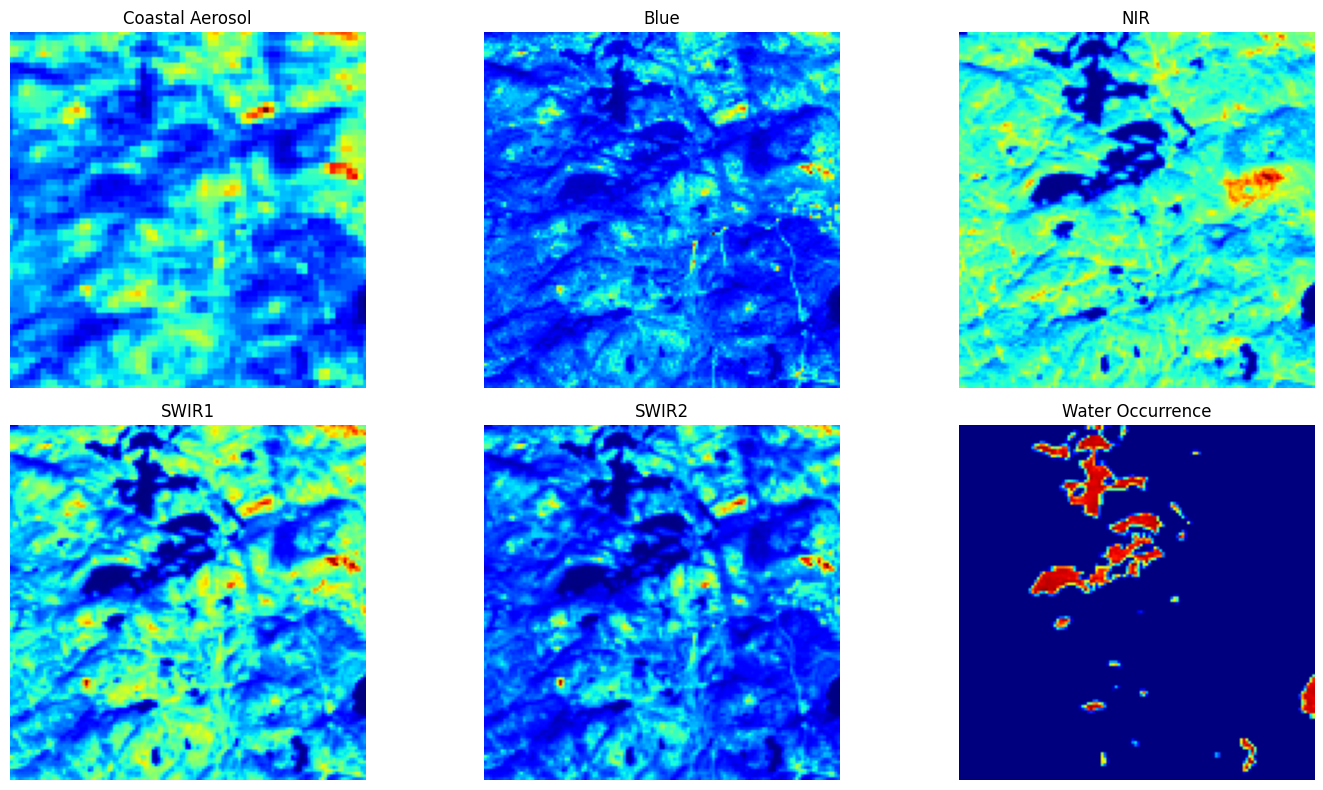

In [15]:
plt.figure(figsize=(15,8))

band_names = [
    "Coastal Aerosol",
    "Blue",
    "NIR",
    "SWIR1",
    "SWIR2",
    "Water Occurrence"
]

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(sample_image[:,:,selected_bands[i]], cmap='jet')
    plt.title(band_names[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [16]:
from torch.utils.data import Subset

dataset = WaterDataset(image_dir, label_dir)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)



In [17]:
model = UNet(in_channels=6, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4 , weight_decay=1e-4)


In [18]:
import matplotlib.pyplot as plt

epochs = 20

train_losses = []
val_losses = []
train_ious = []
val_ious = []


def calculate_metrics(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = (preds * masks).sum()
    FP = (preds * (1 - masks)).sum()
    FN = ((1 - preds) * masks).sum()

    iou = TP / (TP + FP + FN + 1e-8)

    return iou.item() 


for epoch in range(epochs):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0
    train_iou = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        iou = calculate_metrics(preds, masks)
        train_iou += iou

        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)


    train_losses.append(train_loss)
    train_ious.append(train_iou)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    val_iou = 0


    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

        for images, masks in val_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            iou  = calculate_metrics(preds, masks)

            val_iou += iou

            val_bar.set_postfix(val_loss=loss.item())

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)

    val_losses.append(val_loss)
    val_ious.append(val_iou)


    print(f"\nEpoch {epoch+1}")
    print(f"Train -> Loss:{train_loss:.4f} | IoU:{train_iou:.4f}")
    print(f"Val   -> Loss:{val_loss:.4f} | IoU:{val_iou:.4f}\n")



Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.36it/s, val_loss=0.644]



Epoch 1
Train -> Loss:0.4870 | IoU:0.5071
Val   -> Loss:0.6454 | IoU:0.3709



Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.17it/s, val_loss=0.444]



Epoch 2
Train -> Loss:0.3791 | IoU:0.6306
Val   -> Loss:0.4539 | IoU:0.4897



Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.37it/s, val_loss=0.349]



Epoch 3
Train -> Loss:0.3557 | IoU:0.6449
Val   -> Loss:0.3739 | IoU:0.5374



Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.51it/s, val_loss=0.303]



Epoch 4
Train -> Loss:0.3352 | IoU:0.6762
Val   -> Loss:0.3080 | IoU:0.5739



Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.32it/s, val_loss=0.317]



Epoch 5
Train -> Loss:0.3328 | IoU:0.6549
Val   -> Loss:0.3197 | IoU:0.5884



Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.18it/s, val_loss=0.314]



Epoch 6
Train -> Loss:0.3116 | IoU:0.6798
Val   -> Loss:0.3180 | IoU:0.5666



Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.27it/s, val_loss=0.311]



Epoch 7
Train -> Loss:0.3047 | IoU:0.6858
Val   -> Loss:0.3087 | IoU:0.5888



Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.34it/s, val_loss=0.287]



Epoch 8
Train -> Loss:0.3080 | IoU:0.6707
Val   -> Loss:0.2930 | IoU:0.5814



Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s, val_loss=0.29] 



Epoch 9
Train -> Loss:0.2966 | IoU:0.6991
Val   -> Loss:0.2935 | IoU:0.5772



Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.16it/s, val_loss=0.259]



Epoch 10
Train -> Loss:0.3085 | IoU:0.6649
Val   -> Loss:0.2614 | IoU:0.5932



Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.70it/s, val_loss=0.272]



Epoch 11
Train -> Loss:0.2693 | IoU:0.7234
Val   -> Loss:0.2673 | IoU:0.5936



Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.22it/s, val_loss=0.258]



Epoch 12
Train -> Loss:0.2638 | IoU:0.7353
Val   -> Loss:0.2558 | IoU:0.6035



Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.33it/s, val_loss=0.263]



Epoch 13
Train -> Loss:0.2822 | IoU:0.6905
Val   -> Loss:0.2592 | IoU:0.5911



Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.50it/s, val_loss=0.247]



Epoch 14
Train -> Loss:0.2617 | IoU:0.7298
Val   -> Loss:0.2503 | IoU:0.5966



Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.17it/s, val_loss=0.255]



Epoch 15
Train -> Loss:0.2647 | IoU:0.7064
Val   -> Loss:0.2787 | IoU:0.5786



Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.25it/s, val_loss=0.245]



Epoch 16
Train -> Loss:0.2499 | IoU:0.7365
Val   -> Loss:0.2460 | IoU:0.6230



Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.05it/s, val_loss=0.242]



Epoch 17
Train -> Loss:0.2390 | IoU:0.7527
Val   -> Loss:0.2507 | IoU:0.6417



Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.11it/s, val_loss=0.222]



Epoch 18
Train -> Loss:0.2491 | IoU:0.7373
Val   -> Loss:0.2301 | IoU:0.6326



Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.95it/s, val_loss=0.278]



Epoch 19
Train -> Loss:0.2528 | IoU:0.6989
Val   -> Loss:0.2679 | IoU:0.6323



Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.28it/s, val_loss=0.228]


Epoch 20
Train -> Loss:0.2477 | IoU:0.7327
Val   -> Loss:0.2345 | IoU:0.6292



In [19]:
model.eval()

TP = FP = FN = 0

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = torch.sigmoid(model(images))
        preds = (outputs > 0.2).float()

        TP += (preds * masks).sum().item()
        FP += (preds * (1 - masks)).sum().item()
        FN += ((1 - preds) * masks).sum().item()

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
iou = TP / (TP + FP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("\nEval:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"IoU:       {iou:.4f}")
print(f"F1-score:  {f1:.4f}")


Testing: 100%|██████████| 3/3 [00:00<00:00,  6.71it/s]


Eval:
Precision: 0.6981
Recall:    0.9179
IoU:       0.6571
F1-score:  0.7931


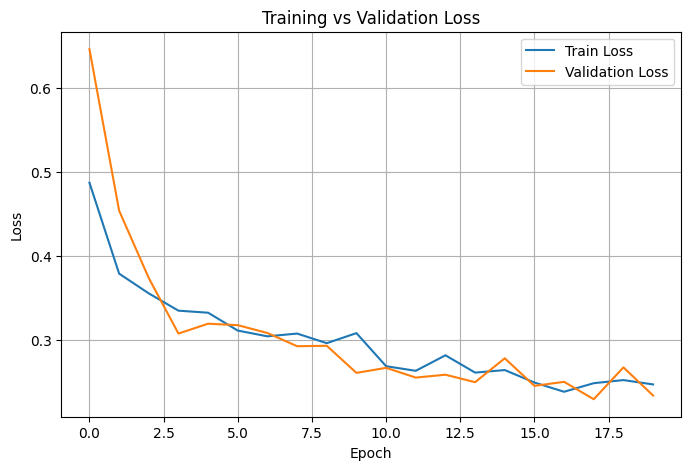

In [20]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


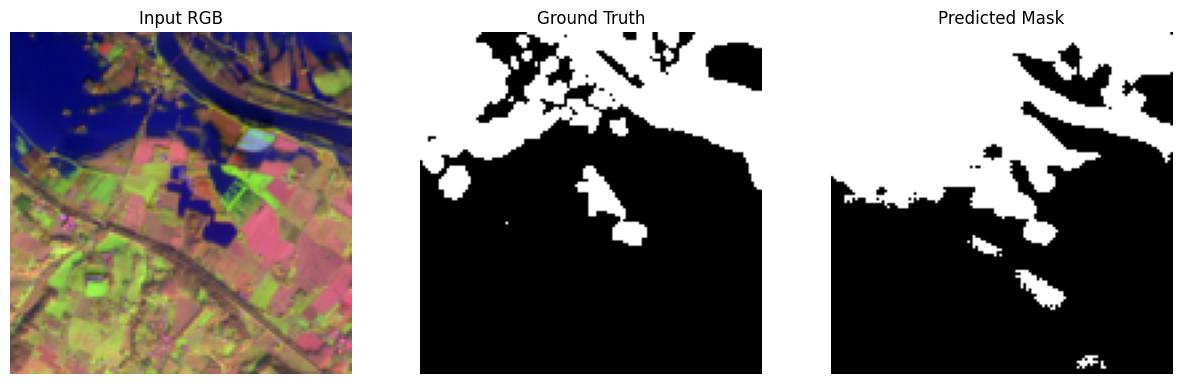

In [21]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)

    outputs = torch.sigmoid(model(images))
    preds = (outputs > 0.5).float()

images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

img = images[0]
gt = masks[0][0]
pred = preds[0][0]

rgb = torch.stack([img[3], img[2], img[1]], dim=0)
rgb = rgb.permute(1,2,0)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


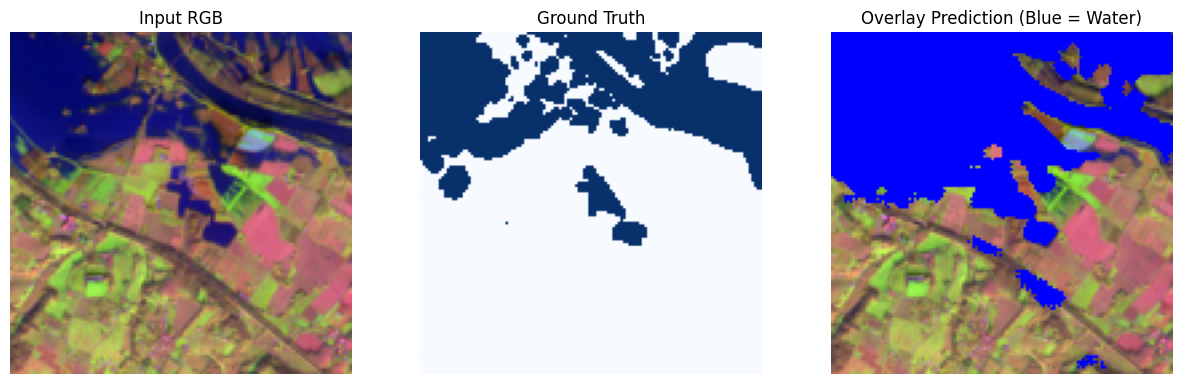

In [22]:
rgb_np = rgb.numpy()

overlay = rgb_np.copy()

overlay[pred.numpy() == 1] = [0, 0, 1]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb_np)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="Blues")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay Prediction (Blue = Water)")
plt.axis("off")

plt.show()


### Model B (6 Bands + NDWI)

In [23]:
class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))

        self.selected_bands = [0, 1, 4, 5, 6, 11]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)

        with rasterio.open(img_path) as src:
            full_image = src.read()  

        full_image = np.transpose(full_image, (1,2,0)).astype(np.float32)
        image = full_image[:, :, self.selected_bands]

        green = full_image[:, :, 2]
        nir = full_image[:, :, 4]

        ndwi = (green - nir) / (green + nir + 1e-8)
        ndwi = np.expand_dims(ndwi, axis=-1)
        image = np.concatenate([image, ndwi], axis=-1)

        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        image = torch.tensor(image).permute(2,0,1)
        mask = torch.tensor(mask).unsqueeze(0)

        return image, mask


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=7, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4 , weight_decay=1e-4)


In [25]:
dataset = WaterDataset(image_dir, label_dir)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [26]:
import matplotlib.pyplot as plt

epochs = 20

train_losses = []
val_losses = []
train_ious = []
val_ious = []


def calculate_metrics(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = (preds * masks).sum()
    FP = (preds * (1 - masks)).sum()
    FN = ((1 - preds) * masks).sum()

    iou = TP / (TP + FP + FN + 1e-8)

    return iou.item()


for epoch in range(epochs):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0
    train_iou = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        iou = calculate_metrics(preds, masks)
        train_iou += iou

        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)


    train_losses.append(train_loss)
    train_ious.append(train_iou)


    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    val_iou = 0


    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

        for images, masks in val_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            iou = calculate_metrics(preds, masks)
            val_iou += iou


            val_bar.set_postfix(val_loss=loss.item())

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)


    val_losses.append(val_loss)
    val_ious.append(val_iou)


    print(f"\nEpoch {epoch+1}")
    print(f"Train -> Loss:{train_loss:.4f} | IoU:{train_iou:.4f}")
    print(f"Val   -> Loss:{val_loss:.4f} | IoU:{val_iou:.4f}\n")


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.05it/s, val_loss=0.627]



Epoch 1
Train -> Loss:0.5182 | IoU:0.5157
Val   -> Loss:0.6269 | IoU:0.0063



Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.04it/s, val_loss=0.475]



Epoch 2
Train -> Loss:0.4007 | IoU:0.6233
Val   -> Loss:0.4781 | IoU:0.4472



Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.30it/s, val_loss=0.365]



Epoch 3
Train -> Loss:0.3633 | IoU:0.6539
Val   -> Loss:0.3629 | IoU:0.6120



Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.09it/s, val_loss=0.321]



Epoch 4
Train -> Loss:0.3521 | IoU:0.6399
Val   -> Loss:0.3204 | IoU:0.6874



Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s, val_loss=0.324]



Epoch 5
Train -> Loss:0.3405 | IoU:0.6458
Val   -> Loss:0.3199 | IoU:0.6877



Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.92it/s, val_loss=0.32] 



Epoch 6
Train -> Loss:0.3339 | IoU:0.6386
Val   -> Loss:0.3132 | IoU:0.7060



Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.24it/s, val_loss=0.308]



Epoch 7
Train -> Loss:0.3544 | IoU:0.6208
Val   -> Loss:0.3050 | IoU:0.6938



Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s, val_loss=0.32] 



Epoch 8
Train -> Loss:0.3120 | IoU:0.6749
Val   -> Loss:0.3087 | IoU:0.7018



Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.58it/s, val_loss=0.299]



Epoch 9
Train -> Loss:0.3146 | IoU:0.6510
Val   -> Loss:0.2992 | IoU:0.7120



Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s, val_loss=0.275]



Epoch 10
Train -> Loss:0.3104 | IoU:0.6405
Val   -> Loss:0.2750 | IoU:0.7307



Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.94it/s, val_loss=0.289]



Epoch 11
Train -> Loss:0.2869 | IoU:0.6975
Val   -> Loss:0.2837 | IoU:0.7270



Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.43it/s, val_loss=0.274]



Epoch 12
Train -> Loss:0.2787 | IoU:0.7011
Val   -> Loss:0.2716 | IoU:0.7418



Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.91it/s, val_loss=0.283]



Epoch 13
Train -> Loss:0.2874 | IoU:0.6889
Val   -> Loss:0.2740 | IoU:0.7219



Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.97it/s, val_loss=0.306]



Epoch 14
Train -> Loss:0.2863 | IoU:0.6795
Val   -> Loss:0.2966 | IoU:0.6944



Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.89it/s, val_loss=0.265]



Epoch 15
Train -> Loss:0.2731 | IoU:0.6948
Val   -> Loss:0.2753 | IoU:0.7383



Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.03it/s, val_loss=0.262]



Epoch 16
Train -> Loss:0.2708 | IoU:0.7031
Val   -> Loss:0.2461 | IoU:0.7612



Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.92it/s, val_loss=0.277]



Epoch 17
Train -> Loss:0.2646 | IoU:0.7047
Val   -> Loss:0.2846 | IoU:0.7263



Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.99it/s, val_loss=0.265]



Epoch 18
Train -> Loss:0.2529 | IoU:0.7268
Val   -> Loss:0.2466 | IoU:0.7379



Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.25it/s, val_loss=0.257]



Epoch 19
Train -> Loss:0.2472 | IoU:0.7323
Val   -> Loss:0.2442 | IoU:0.7599



Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.03it/s, val_loss=0.259]


Epoch 20
Train -> Loss:0.2442 | IoU:0.7229
Val   -> Loss:0.2449 | IoU:0.7566



In [27]:
model.eval()

TP = FP = FN = 0

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = torch.sigmoid(model(images))
        preds = (outputs > 0.2).float()

        TP += (preds * masks).sum().item()
        FP += (preds * (1 - masks)).sum().item()
        FN += ((1 - preds) * masks).sum().item()

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
iou = TP / (TP + FP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("\nEval:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"IoU:       {iou:.4f}")
print(f"F1-score:  {f1:.4f}")


Testing: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


Eval:
Precision: 0.6927
Recall:    0.8747
IoU:       0.6302
F1-score:  0.7731


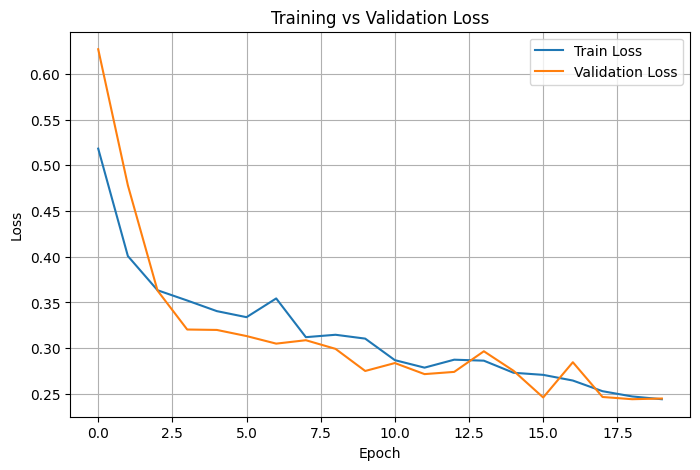

In [28]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


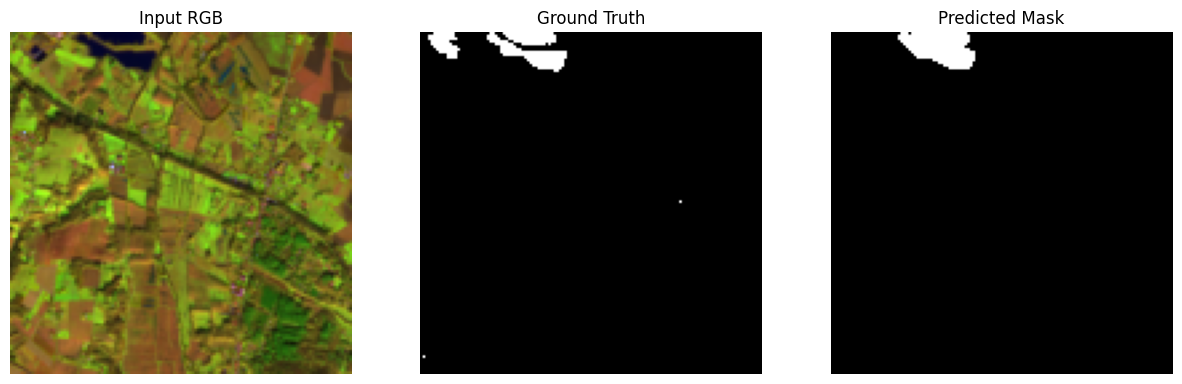

In [29]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)

    outputs = torch.sigmoid(model(images))
    preds = (outputs > 0.5).float()

images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

img = images[0]
gt = masks[0][0]
pred = preds[0][0]

rgb = torch.stack([img[3], img[2], img[1]], dim=0)
rgb = rgb.permute(1,2,0)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


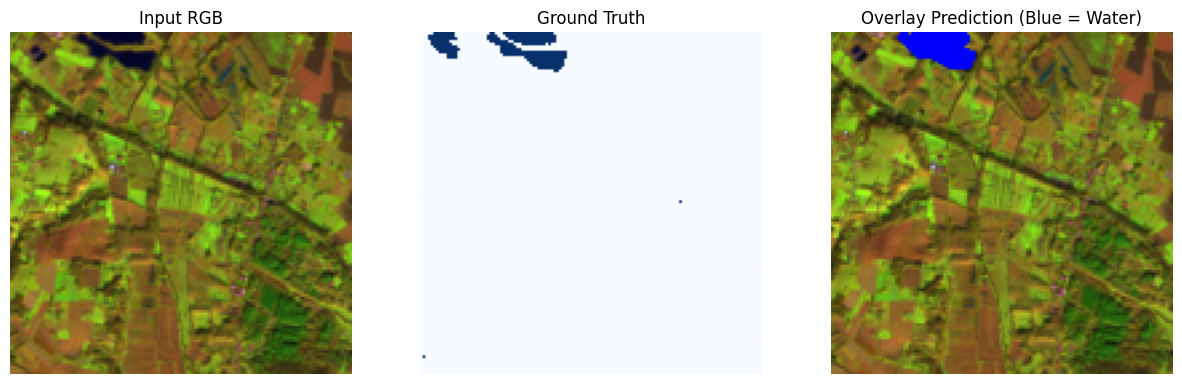

In [30]:
rgb_np = rgb.numpy()

overlay = rgb_np.copy()

overlay[pred.numpy() == 1] = [0, 0, 1]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb_np)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="Blues")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay Prediction (Blue = Water)")
plt.axis("off")

plt.show()


### Model C ---> NIR+SWIR

In [35]:
class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))

        self.selected_bands = [4,5,6]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)

        with rasterio.open(img_path) as src:
            full_image = src.read()  

        full_image = np.transpose(full_image, (1,2,0)).astype(np.float32)
        image = full_image[:, :, self.selected_bands]


        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        image = torch.tensor(image).permute(2,0,1)
        mask = torch.tensor(mask).unsqueeze(0)

        return image, mask


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=3, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4 , weight_decay=1e-4)


In [37]:
dataset = WaterDataset(image_dir, label_dir)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [38]:
import matplotlib.pyplot as plt

epochs = 20

train_losses = []
val_losses = []
train_ious = []
val_ious = []


def calculate_metrics(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = (preds * masks).sum()
    FP = (preds * (1 - masks)).sum()
    FN = ((1 - preds) * masks).sum()

    iou = TP / (TP + FP + FN + 1e-8)

    return iou.item()


for epoch in range(epochs):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0
    train_iou = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        iou = calculate_metrics(preds, masks)
        train_iou += iou

        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)


    train_losses.append(train_loss)
    train_ious.append(train_iou)


    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    val_iou = 0


    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

        for images, masks in val_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            iou = calculate_metrics(preds, masks)
            val_iou += iou


            val_bar.set_postfix(val_loss=loss.item())

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)


    val_losses.append(val_loss)
    val_ious.append(val_iou)


    print(f"\nEpoch {epoch+1}")
    print(f"Train -> Loss:{train_loss:.4f} | IoU:{train_iou:.4f}")
    print(f"Val   -> Loss:{val_loss:.4f} | IoU:{val_iou:.4f}\n")


Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.78it/s, val_loss=0.688]



Epoch 1
Train -> Loss:0.5502 | IoU:0.4436
Val   -> Loss:0.6877 | IoU:0.3692



Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.19it/s, val_loss=0.507]



Epoch 2
Train -> Loss:0.4424 | IoU:0.5635
Val   -> Loss:0.5361 | IoU:0.5957



Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.94it/s, val_loss=0.346]



Epoch 3
Train -> Loss:0.3980 | IoU:0.5977
Val   -> Loss:0.3875 | IoU:0.6623



Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s, val_loss=0.313]



Epoch 4
Train -> Loss:0.3769 | IoU:0.6126
Val   -> Loss:0.3664 | IoU:0.6190



Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.38it/s, val_loss=0.336]



Epoch 5
Train -> Loss:0.3856 | IoU:0.5996
Val   -> Loss:0.3912 | IoU:0.7077



Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.92it/s, val_loss=0.284]



Epoch 6
Train -> Loss:0.3776 | IoU:0.5843
Val   -> Loss:0.3291 | IoU:0.7120



Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s, val_loss=0.259]



Epoch 7
Train -> Loss:0.3595 | IoU:0.6207
Val   -> Loss:0.3033 | IoU:0.6920



Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.54it/s, val_loss=0.25]



Epoch 8
Train -> Loss:0.3557 | IoU:0.6114
Val   -> Loss:0.3071 | IoU:0.7192



Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.40it/s, val_loss=0.262]



Epoch 9
Train -> Loss:0.3548 | IoU:0.6067
Val   -> Loss:0.3051 | IoU:0.7206



Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.70it/s, val_loss=0.255]



Epoch 10
Train -> Loss:0.3405 | IoU:0.6248
Val   -> Loss:0.3200 | IoU:0.7114



Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.12it/s, val_loss=0.255]



Epoch 11
Train -> Loss:0.3275 | IoU:0.6444
Val   -> Loss:0.2976 | IoU:0.7366



Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.26it/s, val_loss=0.253]



Epoch 12
Train -> Loss:0.3221 | IoU:0.6457
Val   -> Loss:0.2840 | IoU:0.7395



Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.42it/s, val_loss=0.228]



Epoch 13
Train -> Loss:0.3208 | IoU:0.6543
Val   -> Loss:0.2752 | IoU:0.7365



Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.61it/s, val_loss=0.239]



Epoch 14
Train -> Loss:0.3141 | IoU:0.6478
Val   -> Loss:0.3099 | IoU:0.7111



Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.79it/s, val_loss=0.251]



Epoch 15
Train -> Loss:0.3078 | IoU:0.6650
Val   -> Loss:0.2896 | IoU:0.7455



Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.70it/s, val_loss=0.217]



Epoch 16
Train -> Loss:0.3030 | IoU:0.6628
Val   -> Loss:0.2563 | IoU:0.7529



Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.56it/s, val_loss=0.307]



Epoch 17
Train -> Loss:0.2901 | IoU:0.6892
Val   -> Loss:0.3532 | IoU:0.6945



Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.64it/s, val_loss=0.238]



Epoch 18
Train -> Loss:0.3156 | IoU:0.6474
Val   -> Loss:0.2962 | IoU:0.7201



Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.61it/s, val_loss=0.232]



Epoch 19
Train -> Loss:0.2939 | IoU:0.6641
Val   -> Loss:0.2736 | IoU:0.7290



Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.59it/s, val_loss=0.236]


Epoch 20
Train -> Loss:0.2900 | IoU:0.6709
Val   -> Loss:0.2761 | IoU:0.7166



In [39]:
model.eval()

TP = FP = FN = 0

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = torch.sigmoid(model(images))
        preds = (outputs > 0.2).float()

        TP += (preds * masks).sum().item()
        FP += (preds * (1 - masks)).sum().item()
        FN += ((1 - preds) * masks).sum().item()

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
iou = TP / (TP + FP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("\nEval:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"IoU:       {iou:.4f}")
print(f"F1-score:  {f1:.4f}")


Testing: 100%|██████████| 3/3 [00:00<00:00,  6.80it/s]


Eval:
Precision: 0.5365
Recall:    0.9565
IoU:       0.5237
F1-score:  0.6874


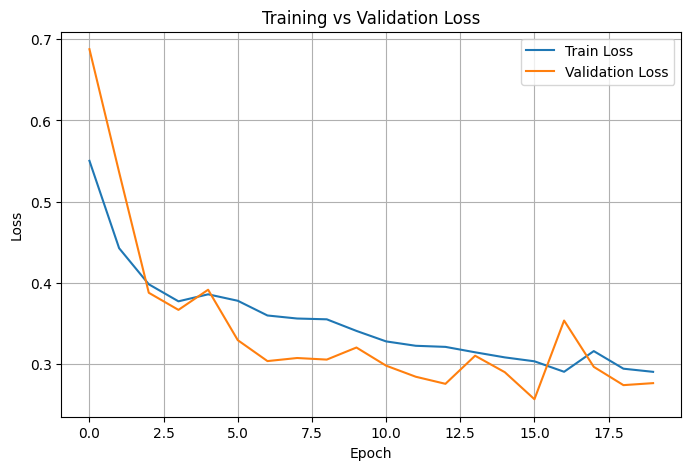

In [40]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


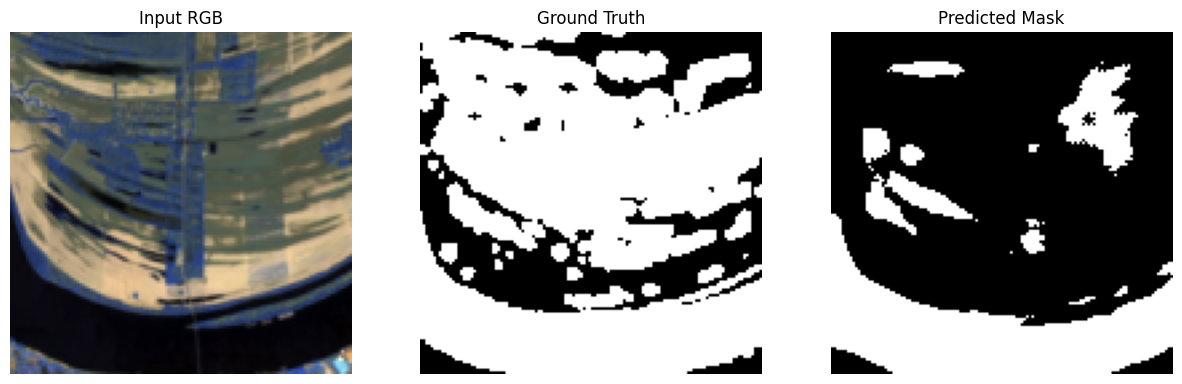

In [43]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)

    outputs = torch.sigmoid(model(images))
    preds = (outputs > 0.5).float()

images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

img = images[0]
gt = masks[0][0]
pred = preds[0][0]

rgb = torch.stack([img[2], img[1], img[0]], dim=0)
rgb = rgb.permute(1,2,0)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


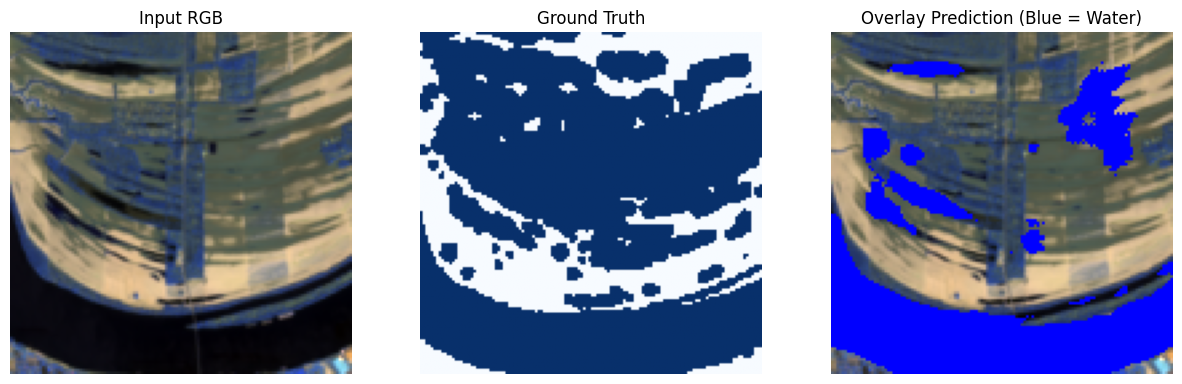

In [44]:
rgb_np = rgb.numpy()

overlay = rgb_np.copy()

overlay[pred.numpy() == 1] = [0, 0, 1]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb_np)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="Blues")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay Prediction (Blue = Water)")
plt.axis("off")

plt.show()
